<a href="https://colab.research.google.com/github/spdavis5/ai-stylistic-fingerprints/blob/main/Classificatrion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages and Link to Drive


In [ ]:
#Packages
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.sentiment import SentimentIntensityAnalyzer

#Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load and Sample Data

In [ ]:
dataset = 3
#Data (From the cleaned CSV file made by process_and_eda.ipynb)
df = pd.read_csv(f'/content/drive/MyDrive/LING 581/TextClassificationProject/processed_dataset{dataset}.csv')

print(df.columns)
#Take smaller amount of rows to reduce processing time
# sample_size = 100000
# df = df.sample(n=sample_size, random_state=42)
#Reset index to make sure it lines up after sample
df.reset_index(drop=True, inplace=True)

print(df['generated'].value_counts())

#y will always be 0 or 1 depending on if the text is generated by AI or not
y = df["generated"]
# Print first 5 rows
df.head()

Index(['text', 'generated'], dtype='object')
generated
0    16091
1    11182
Name: count, dtype: int64


,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept gai...",1
2,A Sustainable Urban Future Car-free cities are...,1
3,Pioneering Sustainable Urban Living In an era ...,1
4,The Path to Sustainable Urban Living In an age...,1


## Extract Stylistic Features

In [ ]:
# Resources
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Initialize tools
sia = SentimentIntensityAnalyzer()
stop_words = set(nltk.corpus.stopwords.words('english'))

# Function to count syllables
def count_syllables(word):
    word = word.lower()
    count = 0
    vowels = "aeiouy"
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

# List to collect features row by row
style_features = []

# Start counter
counter = 0

for text in df['text']:
    # Make sure text is string
    text = str(text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Add tokens to word list
    words = []
    for w in tokens:
        words.append(w)

    # Keep track of number of words
    num_words = len(words)

# COMPLEXITY + READABILITY
# 1. Average Word Length
    total_chars = 0
    for w in words:
        total_chars += len(w)
    avg_word_len = total_chars / num_words

    # Sentence processing
    sentences = nltk.sent_tokenize(text)
    num_sentences = len(sentences)
    if num_sentences == 0:
        num_sentences = 1

    # Average Sentence Length and Variation
    sent_lengths = []
    for s in sentences:
        s_tokens = nltk.word_tokenize(s)
        sent_lengths.append(len(s_tokens))

    if len(sent_lengths) > 0:
        #Average sentence length
        avg_sent_len = np.mean(sent_lengths)
        #Variation
        sent_len_std = np.std(sent_lengths)
    else:
        avg_sent_len = 0
        sent_len_std = 0

    # Syllable counting
    total_syllables = 0
    complex_word_count = 0 # Words with 3+ syllables

    for w in words:
        syl = count_syllables(w)
        total_syllables += syl
        if syl >= 3:
            complex_word_count += 1

    # Flesch Reading Ease
    # 206.835 - 1.015(ASL) - 84.6(ASW)
    flesch_score = 206.835 - (1.015 * avg_sent_len) - (84.6 * (total_syllables / num_words))

    # Gunning Fog Index
    # 0.4 * (ASL + percentage of complex words)
    percent_complex = (complex_word_count / num_words) * 100
    gunning_fog = 0.4 * (avg_sent_len + percent_complex)

# SYNTAX + GRAMMAR
    pos_tags = nltk.pos_tag(words)

    noun_count = 0
    pronoun_count = 0
    aux_count = 0
    adj_count = 0
    adv_count = 0

    # POS tags counting loop
    for word, tag in pos_tags:
        # Noun Density
        if tag.startswith('NN'):
            noun_count += 1
        # Pronoun Density
        if tag.startswith('PRP'):
            pronoun_count += 1
        # Auxiliary Verb Density
        # MD = Modal (could, will), plus common linking verbs
        if tag == 'MD':
            aux_count += 1
        elif word.lower() in ['is', 'are', 'was', 'were', 'have', 'has', 'had', 'do', 'does', 'did']:
            aux_count += 1
        # Adjective Density
        if tag.startswith('JJ'):
            adj_count += 1
        # Adverb Density
        if tag.startswith('RB'):
            adv_count += 1

    noun_ratio = noun_count / num_words
    pronoun_ratio = pronoun_count / num_words
    aux_ratio = aux_count / num_words
    adj_ratio = adj_count / num_words
    adv_ratio = adv_count / num_words

# TONE + DIVERSITY
# Herdan's C (Lexical Diversity)
    unique_words_set = set()
    for w in words:
        unique_words_set.add(w.lower())
    unique_words_count = len(unique_words_set)

    # C = log(V)/log(N) where V = number of unique words, N = Total words
    try:
        herdans_c = np.log(unique_words_count) / np.log(num_words)
    except:
        herdans_c = 0

    # Simpson's Index (Vocabulary Concentration)
    # Sum of (n/N)^2 for each word type where n = count of that word and N = total words
    # probability that two randomly chosen words from the text are the same.
    word_counts = {}
    for w in words:
        w_lower = w.lower()
        if w_lower in word_counts:
            word_counts[w_lower] += 1
        else:
            word_counts[w_lower] = 1

    simpsons_index = 0
    for count in word_counts.values():
        simpsons_index += (count/num_words)**2

    # Sentiment Polarity
    sentiment = sia.polarity_scores(text)
    compound_sentiment = sentiment['compound']
    # Neutrality
    neutrality_score = sentiment['neu']

    # Punctuation Ratio
    punct_count = 0
    punctuation_marks = ['!', '?', '...', ';', ':']
    for char in text:
        if char in punctuation_marks:
            punct_count += 1

    punct_ratio = punct_count / num_words

# Append all 15 features
    style_features.append([
        avg_word_len, avg_sent_len, sent_len_std, flesch_score, gunning_fog,
        noun_ratio, pronoun_ratio, aux_ratio, adj_ratio, adv_ratio,
        herdans_c, simpsons_index, compound_sentiment, neutrality_score, punct_ratio
    ])

    counter += 1
    if counter % 10000 == 0:
        print(f"Processed {counter} rows")

# Feature names
feature_names = [
    "Avg Word Len", "Avg Sent Len", "Sent Len Std Dev", "Flesch Score", "Gunning Fog",
    "Noun Density", "Pronoun Density", "Aux Verb Density", "Adj Density", "Adv Density",
    "Herdan's C", "Simpson's Index", "Sentiment Polarity", "Neutrality Score", "Punctuation Ratio"
]

# Convert to DataFrame
X_style = pd.DataFrame(style_features, columns=feature_names)

# Save aligned data (Features + Labels)
df_full = pd.concat([df[['text', 'generated']], X_style], axis=1)

Processed 10000 rows
Processed 20000 rows


In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    #Fill in na values
    X_style.fillna(X_style.mean()), y, test_size=0.2, random_state=42, stratify=y
)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train Model
clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
clf.fit(X_train_scaled, y_train)

# Evaluate
preds = clf.predict(X_test_scaled)
acc = accuracy_score(y_test, preds)

print(f"\nAccuracy: {acc}")
print("\nClassification Report:")
print(classification_report(y_test, preds, digits=3))


Accuracy: 0.8878093492208983

Classification Report:
              precision    recall  f1-score   support

           0      0.920     0.888     0.903      3218
           1      0.846     0.888     0.867      2237

    accuracy                          0.888      5455
   macro avg      0.883     0.888     0.885      5455
weighted avg      0.889     0.888     0.888      5455



Feature Importance:
Gunning Fog : 3.6053 ( Predicts AI )
Avg Sent Len : -2.7857 ( Predicts Human )
Avg Word Len : 2.3876 ( Predicts AI )
Simpson's Index : 1.549 ( Predicts AI )
Sent Len Std Dev : -1.4953 ( Predicts Human )
Flesch Score : 0.757 ( Predicts AI )
Herdan's C : 0.7477 ( Predicts AI )
Noun Density : -0.7398 ( Predicts Human )
Adj Density : 0.7118 ( Predicts AI )
Aux Verb Density : -0.4419 ( Predicts Human )
Punctuation Ratio : 0.3688 ( Predicts AI )
Neutrality Score : -0.3118 ( Predicts Human )
Pronoun Density : 0.2858 ( Predicts AI )
Adv Density : 0.1666 ( Predicts AI )
Sentiment Polarity : 0.1476 ( Predicts AI )


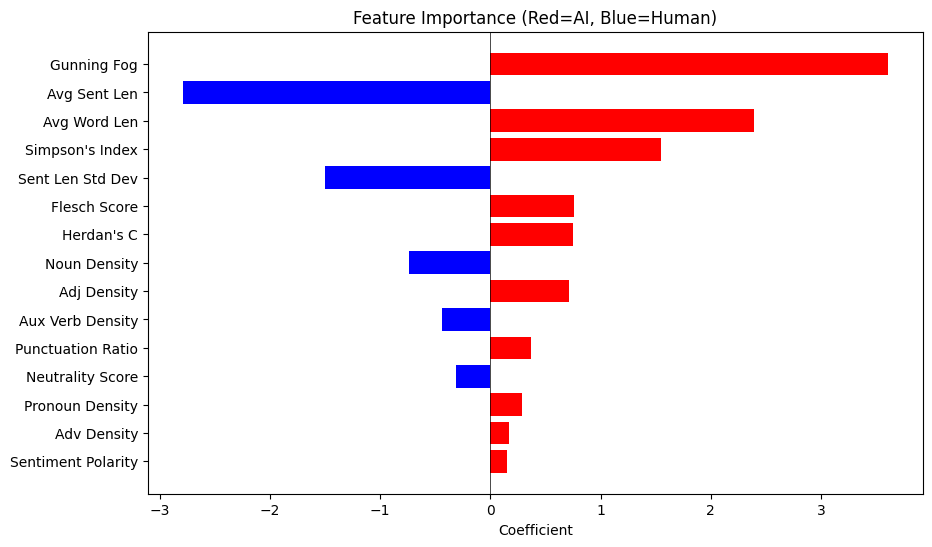

In [ ]:
#Coefficients
coeffs = clf.coef_[0]

# Sort indices with largest first of absolute
indices = sorted(range(len(coeffs)), reverse=True, key=lambda i: abs(coeffs[i]))

# Print feature importance
print("Feature Importance:")
for i in indices:
    coef = coeffs[i]
    interp = "Predicts AI" if coef > 0 else "Predicts Human"
    print(feature_names[i], ":", round(coef, 4), "(", interp, ")")

# Prepare lists for plotting
names = []
values = []
colors = []
for i in indices:
    names.append(feature_names[i])
    values.append(coeffs[i])
    if coeffs[i] > 0:
        colors.append("red")
    else:
        colors.append("blue")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(names, values, color=colors)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlabel("Coefficient")
plt.title("Feature Importance (Red=AI, Blue=Human)")
plt.gca().invert_yaxis()
plt.show()